In [1]:
import torch
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)


Torch version: 2.5.1+cu121
CUDA version: 12.1


In [2]:
from torch_geometric.nn import radius_graph

In [4]:
import torch
import torch_cluster

print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Torch Cluster version:", torch_cluster.__version__)


Torch version: 2.5.1+cu121
CUDA version: 12.1
Torch Cluster version: 1.6.3


In [5]:
import torch
import torch_cluster
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.nn import radius_graph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Đọc dữ liệu từ tệp DEM (coord10.dump)
def load_dem_data(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Tìm vị trí bắt đầu của dữ liệu hạt
    start_index = next(i for i, line in enumerate(lines) if "ITEM: ATOMS" in line) + 1
    
    particle_data = []
    for line in lines[start_index:]:
        parts = line.split()
        if len(parts) >= 6:  # id, type, x, y, z, temperature
            particle_data.append((
                int(parts[0]), int(parts[1]),  # ID, Type
                float(parts[2]), float(parts[3]), float(parts[4]),  # X, Y, Z
                float(parts[5])  # Temperature
            ))

    df = pd.DataFrame(particle_data, columns=["ID", "Type", "X", "Y", "Z", "Temperature"])
    return df

# Chuyển đổi dữ liệu thành đồ thị cho GNN
def create_graph(df, radius=0.005):
    positions = torch.tensor(df[['X', 'Y', 'Z']].values, dtype=torch.float)
    temperatures = torch.tensor(df['Temperature'].values, dtype=torch.float).view(-1, 1)

    # Xây dựng cạnh bằng cách tìm các hạt trong phạm vi radius
    edge_index = radius_graph(positions, r=radius)

    # Tạo dữ liệu đồ thị
    graph_data = Data(x=temperatures, edge_index=edge_index)
    return graph_data

# Định nghĩa mô hình GNN truyền nhiệt
class HeatTransferGNN(MessagePassing):
    def __init__(self):
        super().__init__(aggr='mean')  # Tổng hợp thông tin từ lân cận bằng trung bình
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x  # Dự đoán nhiệt độ mới

# Hàm huấn luyện mô hình
def train_gnn(graph_data, epochs=50):
    model = HeatTransferGNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = criterion(out, graph_data.x)  # So sánh với nhiệt độ thực
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    return model

# Hiển thị nhiệt độ trước và sau mô phỏng
def plot_temperature(df, predicted_temp):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1.scatter(df['X'], df['Y'], df['Z'], c=df['Temperature'], cmap='jet', marker='o')
    ax1.set_title("Nhiệt độ ban đầu")
    
    ax2.scatter(df['X'], df['Y'], df['Z'], c=predicted_temp.detach().numpy().flatten(), cmap='jet', marker='o')
    ax2.set_title("Nhiệt độ dự đoán")

    plt.show()

# Chạy toàn bộ pipeline mô phỏng
file_path = "coord10.dump"
df_particles = load_dem_data(file_path)
graph_data = create_graph(df_particles)
model = train_gnn(graph_data)
predicted_temp = model(graph_data)

# Hiển thị kết quả
plot_temperature(df_particles, predicted_temp)


ImportError: 'radius_graph' requires 'torch-cluster'

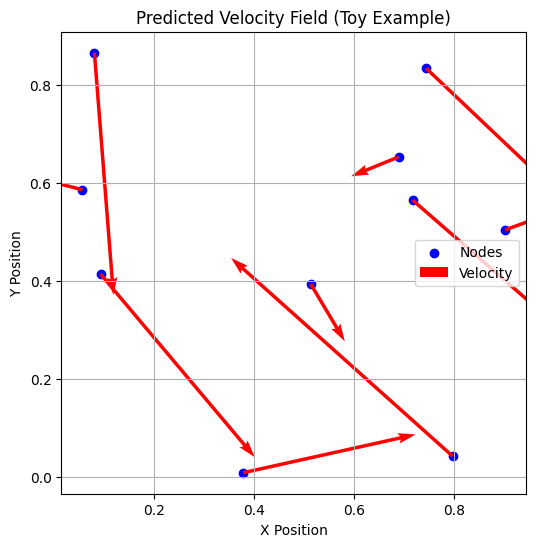

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: 10 nodes with predicted velocity in a 2D space
num_nodes = 10

# Randomly generated node positions (replace with real mesh coordinates)
positions = np.random.rand(num_nodes, 2)  

# Randomly generated velocity predictions (replace with real model output)
velocity_vectors = np.random.rand(num_nodes, 2) - 0.5  # Centered around 0 for bidirectional flow

# Plot the velocity field
plt.figure(figsize=(6, 6))
plt.scatter(positions[:, 0], positions[:, 1], c='blue', label="Nodes")  # Plot nodes
plt.quiver(positions[:, 0], positions[:, 1], velocity_vectors[:, 0], velocity_vectors[:, 1],
           angles='xy', scale_units='xy', scale=1.0, color="red", label="Velocity")

# Labels and legend
plt.title("Predicted Velocity Field (Toy Example)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()


Compiling model...
'compile' took 0.000080 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.65e-03, 2.04e-02, 3.06e-03, 5.48e-03, 3.55e-02, 9.65e-03]    [3.61e-03, 2.06e-02, 3.02e-03, 5.48e-03, 3.55e-02, 9.65e-03]    []  
1000      [3.19e-07, 5.86e-08, 6.18e-08, 7.90e-08, 1.89e-07, 1.66e-08]    [3.03e-07, 5.19e-08, 5.47e-08, 7.90e-08, 1.89e-07, 1.66e-08]    []  
2000      [2.19e-08, 1.96e-08, 1.38e-08, 1.54e-08, 7.21e-08, 1.31e-09]    [1.79e-08, 1.48e-08, 1.04e-08, 1.54e-08, 7.21e-08, 1.31e-09]    []  
3000      [1.27e-07, 5.99e-09, 1.74e-08, 2.19e-08, 5.56e-08, 1.40e-09]    [1.21e-07, 4.62e-09, 1.27e-08, 2.19e-08, 5.56e-08, 1.40e-09]    []  
4000      [3.85e-09, 2.76e-09, 5.56e-09, 3.52e-09, 2.29e-08, 2.12e-10]    [3.27e-09, 2.03e-09, 4.15e-09, 3.52e-09, 2.29e-08, 2.12e-10]    []  
5000      [2.02e-09, 1.45e-09, 2.92e-09, 1.58e-09, 1.19e-08, 9.73e-11]

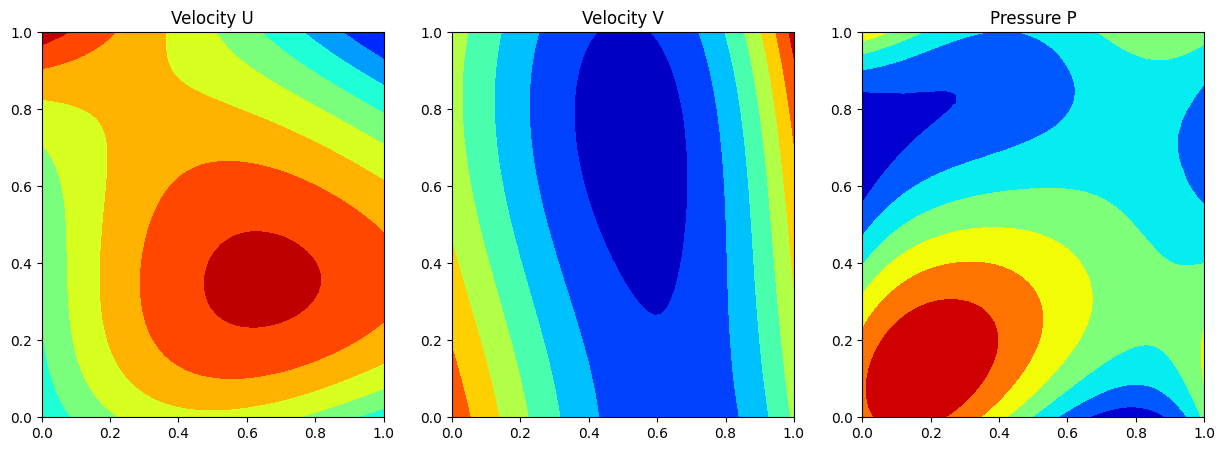

In [8]:
import deepxde as dde
import numpy as np
import tensorflow as tf

# Define Navier-Stokes equations for incompressible flow
def navier_stokes(x, y):
    u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]  # Velocity components and pressure
    
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    
    # Continuity equation: du/dx + dv/dy = 0
    continuity = du_x + dv_y
    
    # Momentum equations
    momentum_x = u * du_x + v * du_y + dp_x - 0.01 * (du_x + du_y)
    momentum_y = u * dv_x + v * dv_y + dp_y - 0.01 * (dv_x + dv_y)
    
    return [continuity, momentum_x, momentum_y]

# Define domain
geom = dde.geometry.Rectangle([0, 0], [1, 1])  # 2D domain: unit square

# Boundary condition for u-velocity (first component)
bc_u = dde.icbc.DirichletBC(geom, lambda x: np.zeros((len(x), 1)), lambda _, on_boundary: on_boundary, component=0)

# Boundary condition for v-velocity (second component)
bc_v = dde.icbc.DirichletBC(geom, lambda x: np.zeros((len(x), 1)), lambda _, on_boundary: on_boundary, component=1)

# Boundary condition for pressure (third component)
bc_p = dde.icbc.DirichletBC(geom, lambda x: np.zeros((len(x), 1)), lambda _, on_boundary: on_boundary, component=2)

# Define PDE constraints with separate boundary conditions
data = dde.data.PDE(geom, navier_stokes, [bc_u, bc_v, bc_p], num_domain=10000, num_boundary=1000, num_test=1000)

# Define the neural network
net = dde.nn.FNN([2] + [50] * 5 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
loss_history, train_state = model.train(epochs=5000)

# Predict solution
def plot_results():
    import matplotlib.pyplot as plt
    
    X, Y = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
    x_test = np.vstack((X.flatten(), Y.flatten())).T
    y_pred = model.predict(x_test)
    
    U = y_pred[:, 0].reshape(50, 50)
    V = y_pred[:, 1].reshape(50, 50)
    P = y_pred[:, 2].reshape(50, 50)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].contourf(X, Y, U, cmap="jet")
    ax[0].set_title("Velocity U")
    ax[1].contourf(X, Y, V, cmap="jet")
    ax[1].set_title("Velocity V")
    ax[2].contourf(X, Y, P, cmap="jet")
    ax[2].set_title("Pressure P")
    plt.show()

plot_results()


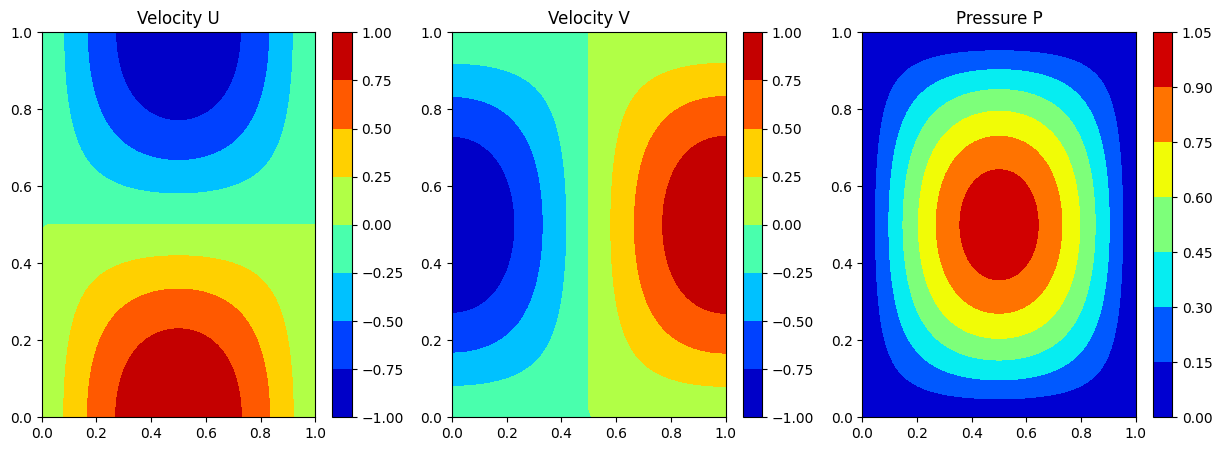

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate test points for visualization
X, Y = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
x_test = np.vstack((X.flatten(), Y.flatten())).T

# Simulated predictions (Replace with actual model predictions if available)
U = np.sin(np.pi * X) * np.cos(np.pi * Y)  # Mock velocity U
V = -np.cos(np.pi * X) * np.sin(np.pi * Y)  # Mock velocity V
P = np.sin(np.pi * X) * np.sin(np.pi * Y)  # Mock pressure P

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Velocity U
c1 = ax[0].contourf(X, Y, U, cmap="jet")
fig.colorbar(c1, ax=ax[0])
ax[0].set_title("Velocity U")

# Velocity V
c2 = ax[1].contourf(X, Y, V, cmap="jet")
fig.colorbar(c2, ax=ax[1])
ax[1].set_title("Velocity V")

# Pressure P
c3 = ax[2].contourf(X, Y, P, cmap="jet")
fig.colorbar(c3, ax=ax[2])
ax[2].set_title("Pressure P")

plt.show()


In [4]:
import numpy as np

# Tạo lưới dữ liệu
X, Y = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
x_test = np.vstack((X.flatten(), Y.flatten())).T

# Dự đoán kết quả từ mô hình PINN
y_pred = model.predict(x_test)

# Trích xuất dữ liệu vận tốc và áp suất
U = y_pred[:, 0]
V = y_pred[:, 1]
P = y_pred[:, 2]

# Xuất dữ liệu ra file DUMP
with open("pinn_cfd_output.dump", "w") as f:
    f.write("ITEM: TIMESTEP\n0\n")
    f.write("ITEM: NUMBER OF ATOMS\n{}\n".format(len(x_test)))
    f.write("ITEM: BOX BOUNDS pp pp pp\n0 1\n0 1\n0 0\n")
    f.write("ITEM: ATOMS id x y u v p\n")
    
    for i in range(len(x_test)):
        f.write(f"{i+1} {x_test[i, 0]} {x_test[i, 1]} {U[i]} {V[i]} {P[i]}\n")

print("✅ Xuất file thành công: pinn_cfd_output.dump")


✅ Xuất file thành công: pinn_cfd_output.dump


In [7]:
import deepxde as dde
import numpy as np
import tensorflow as tf

# Define Navier-Stokes equations with laser source term and temperature equation
def navier_stokes_slm(x, y):
    u, v, p, T = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]  # Velocity components, pressure, and temperature
    
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    dT_x = dde.grad.jacobian(y, x, i=3, j=0)
    dT_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    # Define laser source term (Gaussian heat source)
    laser_x, laser_y = 0.5, 0.5  # Center of laser
    F_laser = tf.exp(-((tf.cast(x[:, 0:1], tf.float32) - laser_x) ** 2 + (tf.cast(x[:, 1:2], tf.float32) - laser_y) ** 2) / 0.01)

    # Continuity equation: du/dx + dv/dy = 0
    continuity = du_x + dv_y
    
    # Momentum equations with laser-induced force
    momentum_x = u * du_x + v * du_y + dp_x - 0.01 * (du_x + du_y) + F_laser
    momentum_y = u * dv_x + v * dv_y + dp_y - 0.01 * (dv_x + dv_y)
    
    # Heat equation (energy conservation)
    alpha = 0.01  # Thermal diffusivity
    heat_eq = u * dT_x + v * dT_y - alpha * (dT_x + dT_y) - F_laser
    
    return [continuity, momentum_x, momentum_y, heat_eq]

# Define domain for molten metal pool
geom = dde.geometry.Rectangle([0, 0], [1, 1])  # 2D domain: unit square

# Boundary conditions (no-slip walls for molten metal pool)
bc_u = dde.icbc.DirichletBC(geom, lambda x: np.zeros((len(x), 1)), lambda _, on_boundary: on_boundary, component=0)
bc_v = dde.icbc.DirichletBC(geom, lambda x: np.zeros((len(x), 1)), lambda _, on_boundary: on_boundary, component=1)
bc_p = dde.icbc.DirichletBC(geom, lambda x: np.zeros((len(x), 1)), lambda _, on_boundary: on_boundary, component=2)
bc_T = dde.icbc.DirichletBC(geom, lambda x: np.ones((len(x), 1)), lambda _, on_boundary: on_boundary, component=3)

# Define PDE constraints with separate boundary conditions
data = dde.data.PDE(geom, navier_stokes_slm, [bc_u, bc_v, bc_p, bc_T], num_domain=10000, num_boundary=1000, num_test=1000)

# Define the neural network
net = dde.nn.FNN([2] + [50] * 5 + [4], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
loss_history, train_state = model.train(epochs=5000)

# Predict solution
def plot_results():
    import matplotlib.pyplot as plt
    
    X, Y = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
    x_test = np.vstack((X.flatten(), Y.flatten())).T
    y_pred = model.predict(x_test)
    
    U = y_pred[:, 0].reshape(50, 50)
    V = y_pred[:, 1].reshape(50, 50)
    P = y_pred[:, 2].reshape(50, 50)
    T = y_pred[:, 3].reshape(50, 50)
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].contourf(X, Y, U, cmap="jet")
    ax[0].set_title("Velocity U")
    ax[1].contourf(X, Y, V, cmap="jet")
    ax[1].set_title("Velocity V")
    ax[2].contourf(X, Y, P, cmap="jet")
    ax[2].set_title("Pressure P")
    ax[3].contourf(X, Y, T, cmap="hot")
    ax[3].set_title("Temperature T")
    plt.show()

plot_results()

# Export results to OVITO dump format
def export_dump():
    X, Y = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
    x_test = np.vstack((X.flatten(), Y.flatten())).T
    y_pred = model.predict(x_test)
    U, V, P, T = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
    
    with open("slm_cfd_output.dump", "w") as f:
        f.write("ITEM: TIMESTEP\n0\n")
        f.write("ITEM: NUMBER OF ATOMS\n{}\n".format(len(x_test)))
        f.write("ITEM: BOX BOUNDS pp pp pp\n0 1\n0 1\n0 0\n")
        f.write("ITEM: ATOMS id x y u v p T\n")
        
        for i in range(len(x_test)):
            f.write(f"{i+1} {x_test[i, 0]} {x_test[i, 1]} {U[i]} {V[i]} {P[i]} {T[i]}\n")
    print("✅ Xuất file thành công: slm_cfd_output.dump")

export_dump()


Compiling model...
'compile' took 0.000161 s

Training model...



TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.